In [1]:
import bias

import numpy as nd
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor  # HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ----- Configuration Variables -----

NUMERIC_FEATURES = ["year", "author_seniority", "num_aggl_publications"]
#CATEGORIAL_FEATURES = ["author_gender", "author_country", "author_classification", "author_journal_classification", "author_continent"]
CATEGORIAL_FEATURES = ["author_gender", "author_classification_cluster", "author_journal_classification", "author_continent"] # classification erstmal nicht als feature betrachten
SAMPLING_COLUMN = "num_aggl_publications_cluster"      # name of the feature / column that is used to sample the test data into equally sized data sets
TARGET_FEATURE = "num_aggl_collaborators" # name of the feature / clumn that will be predicted
NUM_FOLDS = 10
RANDOM_STATE = 1

#MODEL = HistGradientBoostingRegressor(max_depth=6, max_leaf_nodes=64)
MODEL = GradientBoostingRegressor(n_estimators=140, min_samples_leaf=5, max_depth=15)

# -----------------------------------

FEATURE_PREPROCESSOR = ColumnTransformer(
    n_jobs=3,
    transformers=[
        ('num',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                #('scaler', StandardScaler())
            ]), NUMERIC_FEATURES),
        ('cat', OneHotEncoder(), CATEGORIAL_FEATURES)  # OneHotEncoder(drop="first")
    ])

## Data import and preprocessing

In [2]:
data = bias.preprocess_dataset("zbmath_simple_collaboration_model_1970-2019.csv",
        categorial_rows=CATEGORIAL_FEATURES + ["author_classification"],
        drop_rows=["author_id", "num_aggl_single_publications", "num_aggl_collaborations"])
        # author_classification: erstmal nicht als feature betrachtet (ansonsten zu viele)
        # num_aggl_single_publications: abhängig von Gesamtanzahl an Publikationen

# Cluster num_aggl_publications and author_classification columns
data = bias.cluster_column(data, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
data = bias.cluster_column(data, bias.EGONET_1_CLUSTERING, "author_classification", newcolumn="author_classification_cluster")
data = data.loc[data.year>=1970]
data.sample(10)

,year,author_gender,author_country,author_seniority,author_classification,author_journal_classification,num_aggl_publications,num_aggl_collaborators,author_continent,num_aggl_publications_cluster,author_classification_cluster
613704,2001,m,CA,38,90,FAST TRACK,33,21,NA,l) 30-50,Probability / Statistics / Operations research
1121309,1989,m,Other,17,03,FAST TRACK,9,0,,h) 9-10,General / Logic / Education
1748086,2017,u,Other,4,60,KAT 1,4,3,,d) 4,Probability / Statistics / Operations research
334340,2017,m,IT,17,65,KAT 1,7,5,EU,g) 7-8,PDE / Numerical / Physics
1398960,2006,u,US,7,76,KAT 2,10,4,NA,h) 9-10,PDE / Numerical / Physics
1602404,2006,f,US,2,34,KAT 2,3,1,NA,c) 3,ODE / Dynamical systems / Other equations
1637365,2010,m,IR,4,05,KAT 3,4,4,AS,d) 4,Graphs / Linear Algebra
2445641,2000,m,US,0,62,KAT 3,1,3,NA,a) 1,Probability / Statistics / Operations research
68287,1988,m,Other,7,34,KAT 1,3,1,EU,c) 3,ODE / Dynamical systems / Other equations
2317015,1988,m,Other,36,42,FAST TRACK,32,13,,l) 30-50,Real & complex functions


## Sampling

In [3]:
dataset = data.reset_index(drop=True) # incremental reindexing to fill index-gaps

# split / select & sample data into two equal sized _final datasets (size is determined by the SAMPLING_COLUMN)
male_all = dataset[dataset.author_gender == "m"]
female_final = dataset[dataset.author_gender == "f"]

_, male_final = bias.sampled_train_test_split(male_all, female_final, SAMPLING_COLUMN, random_state=RANDOM_STATE)

a) 1
b) 2
c) 3
d) 4
e) 5
f) 6
g) 7-8
h) 9-10
i) 11-13
j) 14-18
k) 19-29
l) 30-50
m) >50


## Generate 'normal' and 'switched' data sets

In [4]:
female_final = female_final.drop("num_aggl_publications_cluster", axis=1)
female_final_switched = female_final.copy()
female_final_switched["author_gender"] = "m"

male_final = male_final.drop("num_aggl_publications_cluster", axis=1)
male_final_switched = male_final.copy()
male_final_switched["author_gender"] = "f"

In [5]:
dataset_equal_sample_sizes = pd.concat([female_final, male_final], ignore_index=True)
dataset_equal_sample_sizes_switched = pd.concat([female_final_switched, male_final_switched], ignore_index=True)

In [6]:
print(len(dataset_equal_sample_sizes))
print(len(dataset_equal_sample_sizes_switched))

602398
602398


In [7]:
X, y = bias.X_y_split(dataset_equal_sample_sizes, TARGET_FEATURE)
X_switched, y_switched = bias.X_y_split(dataset_equal_sample_sizes_switched, TARGET_FEATURE)

In [8]:
X_t = FEATURE_PREPROCESSOR.fit_transform(X)
X_switched_t = FEATURE_PREPROCESSOR.transform(X_switched)

feature_names = NUMERIC_FEATURES+list(FEATURE_PREPROCESSOR.transformers_[1][1].get_feature_names())

In [9]:
Df = pd.DataFrame
if FEATURE_PREPROCESSOR.sparse_output_:
    Df = pd.DataFrame.sparse.from_spmatrix

X_t = Df(X_t, columns=feature_names, index=X.index)
X_switched_t = Df(X_switched_t, columns=feature_names, index=X_switched.index)

## Train & evaluate model

In [10]:
fold_results, feature_importance, switched_fold_results = bias.gs_k_fold_eval(
    MODEL,
    NUM_FOLDS,
    X_t,
    y,
    copy=["year", "x0_f", "x0_m", "author_seniority", "num_aggl_publications"],
    feature_names=feature_names,
    random_state=RANDOM_STATE,
    test_only=[(X_switched_t, y_switched)])

Working on fold 1
Working on fold 2
Working on fold 3
Working on fold 4
Working on fold 5
Working on fold 6
Working on fold 7
Working on fold 8
Working on fold 9
Working on fold 10


## Feature importance in trained models

In [11]:
from statistics import mean
for fi in sorted(feature_importance.items(), key=lambda f: mean(f[1]), reverse=True): print(fi)

('num_aggl_publications', [0.7077318626988207, 0.7064867274764045, 0.705218946131353, 0.7071177830636949, 0.7057183821473675, 0.7066115821490351, 0.7049406839491248, 0.7058821859826234, 0.7018264034940912, 0.7081066555876065])
('year', [0.07261723473298369, 0.07346321734727836, 0.07351172364878895, 0.07241781730843852, 0.07395571957751404, 0.0724262004630223, 0.07432918400017656, 0.07341849856368214, 0.07351606838463612, 0.07245214132767668])
('author_seniority', [0.07221107259141278, 0.07050823858817121, 0.07175271382069522, 0.07120836379100715, 0.07192178383194418, 0.07212098044960848, 0.07302459102560481, 0.07133285265928228, 0.07327168480872795, 0.07098309693661474])
('x1_Graphs / Linear Algebra', [0.027314499021133497, 0.030175695652972692, 0.030403701524962613, 0.029886753416661086, 0.028057175623852057, 0.02938461277269214, 0.0271891404669817, 0.02911393158991385, 0.030703726709069245, 0.028386949005024226])
('x3_NA', [0.014359482727392275, 0.013365557987434492, 0.01381273714919

## Comparison of model prediction metrics

In [12]:
import importlib
importlib.reload(bias)

for i in range(len(fold_results)):
    print("Fold: ", i)
    r_train, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    print("Train (normal dataset only)")
    print(bias.stringify_gs_train_result(r_train))
    print("Test (left: normal dataset, right: switched dataset)")
    print(bias.compare_gs_results(r_test, r_switched_test))

Fold:  0
Train (normal dataset only)
Size:	542158
Size F:	271281
Size M:	270877
R2:	0.8538404745468239
R2 F:	0.8768858929346797
R2 M:	0.8297582292395009
MAE:	1.6325752684836987
MAE F:	1.5813826921951772
MAE M:	1.6838441960343093
Mean y:	4.490358899066324
Mean y F:	4.779063037956952
Mean y M:	4.201224171856599
Mean y_hat:	4.4903588990662335
Mean y_hat F:	4.778938538206192
Mean y_hat M:	4.201348857292844

Test (left: normal dataset, right: switched dataset)
Size:	60240		60240
Size F:	29918		30322
Size M:	30322		29918
R2:	0.6863581367072566	0.6490309397876558
R2 F:	0.7786396862436984	0.5644875148930318
R2 M:	0.5885891888564434	0.7286397920287709
MAE:	2.0877564961074033	2.2207808246831755
MAE F:	1.9465886569826307	2.3324945891172923
MAE M:	2.2270434630269653	2.1075585248913686
Mean y F:	4.74867972458052	4.2061209682738605
Mean y M:	4.2061209682738605	4.74867972458052
Mean y_hat F:	4.76419050990128	4.385642904038653
Mean y_hat M:	4.177233488191502	4.531114750776709
WD (F, S(F)=M):	0.2334840

Size:	60240		60240
Size F:	30305		29935
Size M:	29935		30305
R2:	0.7010962757139736	0.658001600694796
R2 F:	0.7743920079953907	0.5828515925407157
R2 M:	0.6157531394583153	0.72236470172341
MAE:	2.100448147326896	2.2442309398679545
MAE F:	1.9564409314322522	2.3651837836974448
MAE M:	2.2462353087662548	2.124754834273637
Mean y F:	4.799274047186933	4.255553699682646
Mean y M:	4.255553699682646	4.799274047186933
Mean y_hat F:	4.765750956690286	4.4596852578563695
Mean y_hat M:	4.248685378310339	4.559538757290887
WD (F, S(F)=M):	0.20621760399569308
WD (F, S(M)=F):	0.3323968972714745
WD (M, S(M)=F):	0.21257344594878846
WD (M, S(F)=M):	0.3451793831931683


Fold:  8
Train (normal dataset only)
Size:	542159
Size F:	271213
Size M:	270946
R2:	0.8616085079539435
R2 F:	0.8846846124458204
R2 M:	0.8373633804812742
MAE:	1.595662671663803
MAE F:	1.5442817021916024
MAE M:	1.6470942738039491
Mean y:	4.49130605597251
Mean y F:	4.7784213883552775
Mean y M:	4.203907789744082
Mean y_hat:	4.491306055972642
Mean

In [13]:
# combine all results for plotting
r_test_all = pd.concat([r[1] for r in fold_results], ignore_index=True)
r_test_all = bias.cluster_column(r_test_all, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
r_switched_test_all = pd.concat(switched_fold_results, ignore_index=True)
r_switched_test_all = bias.cluster_column(r_switched_test_all, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")

In [25]:
# Wasserstein-distances for combined results
from scipy.stats import wasserstein_distance

print("WD (F, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_f"]==1]["y_hat"])))
print("WD (F, S(M)=F):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_m"]==1]["y_hat"])))
print("WD (M, S(M)=F):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_m"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_m"]==1]["y_hat"])))
print("WD (M, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_m"]==1]["y_hat"], r_switched_test_all[r_test_all["x0_f"]==1]["y_hat"])))

WD (F, S(F)=M):	0.21491749126456083
WD (F, S(M)=F):	0.37820073262842585
WD (M, S(M)=F):	0.2139907873343859
WD (M, S(F)=M):	0.3901070605579963


In [5]:
print("WD (F, S(F)=M):\t{}".format(wasserstein_distance(r_test_all[r_test_all["x0_f"]==1]["y_hat"], r_test_all[r_test_all["x0_f"]==1]["y_hat"]+1)))

NameError: name 'r_test_all' is not defined

In [4]:
r_test_all.head()

NameError: name 'r_test_all' is not defined

In [2]:
from scipy.stats import wasserstein_distance

print("Gender difference in data", wasserstein_distance(r_test_all[r_test_all["x0_f"] == 1]["y"], r_test_all[r_test_all["x0_m"] == 1]["y"]))
print("Gender difference in switched data", wasserstein_distance(r_switched_test_all[r_test_all["x0_f"] == 1]["y"], r_switched_test_all[r_test_all["x0_m"] == 1]["y"]))

NameError: name 'r_test_all' is not defined

## Graphical distibution of predictions by document publication year

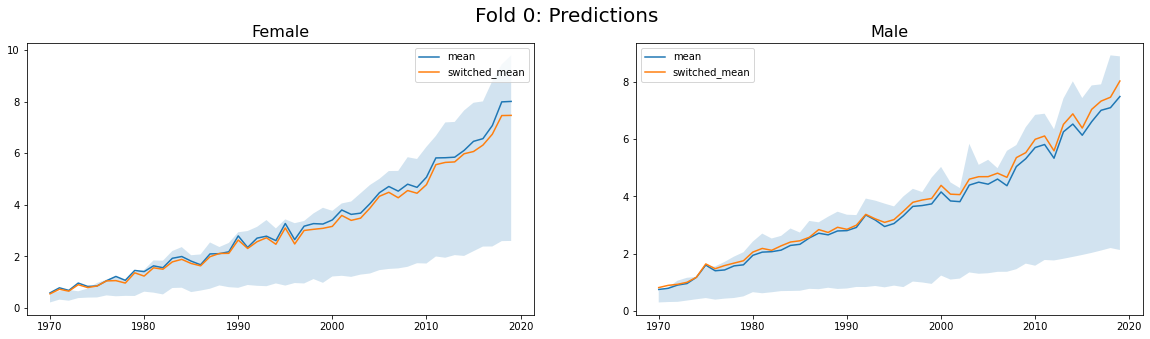

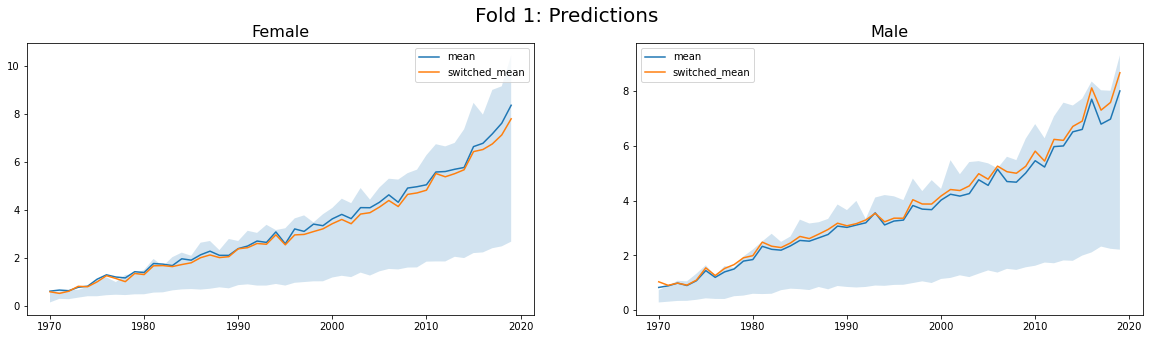

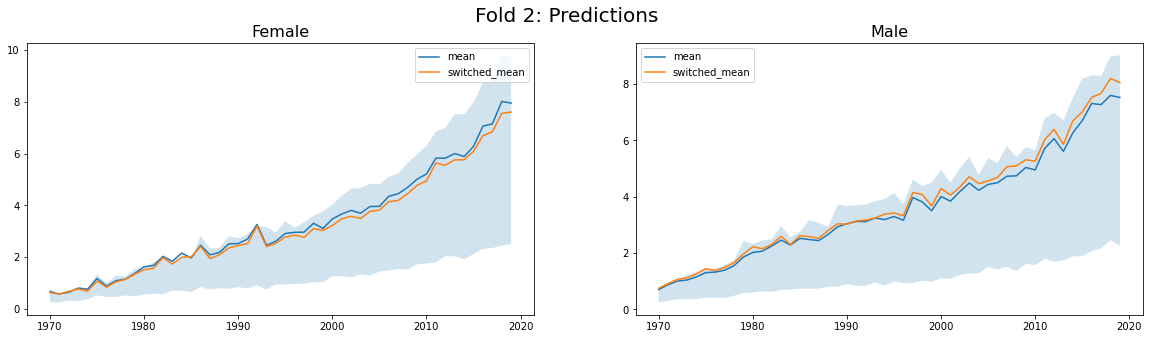

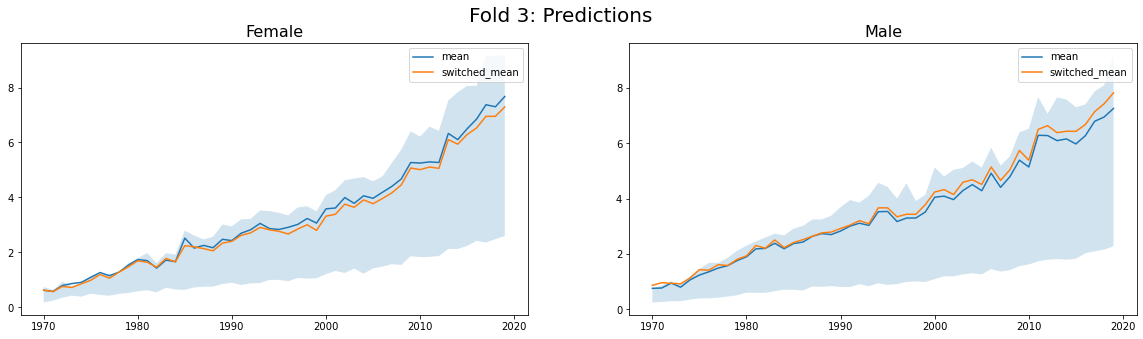

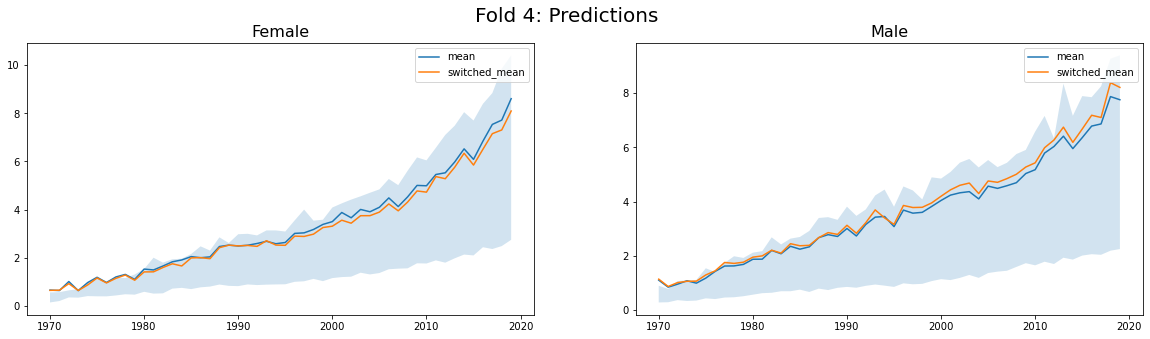

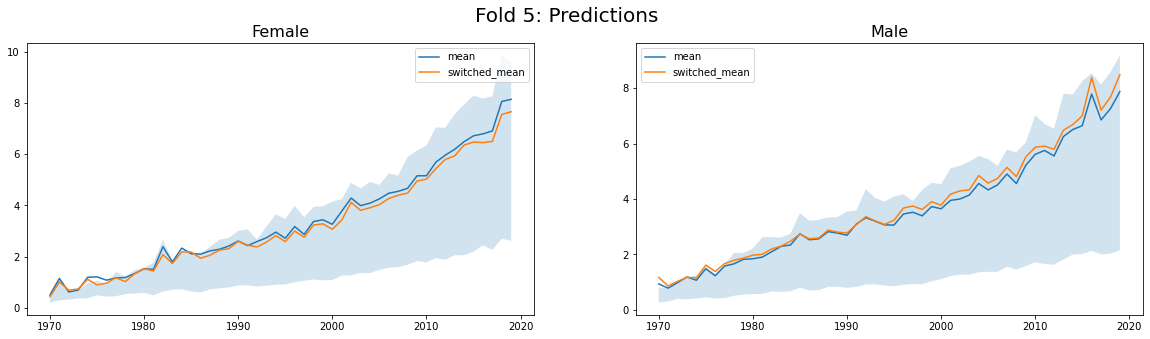

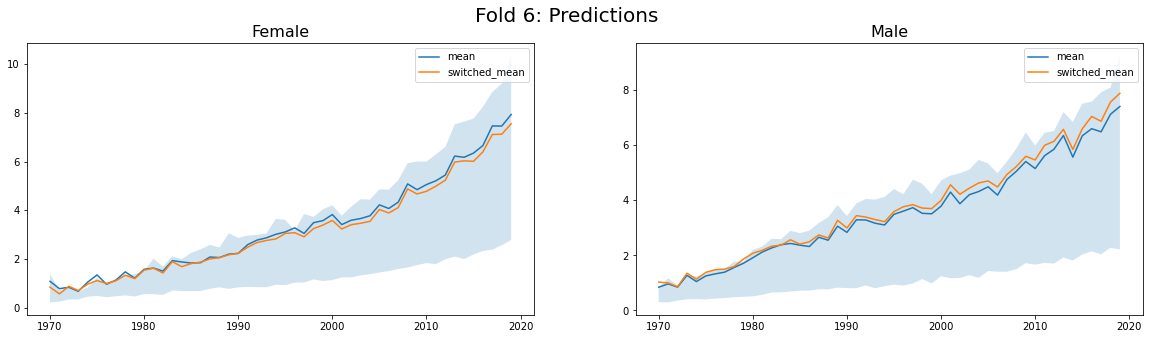

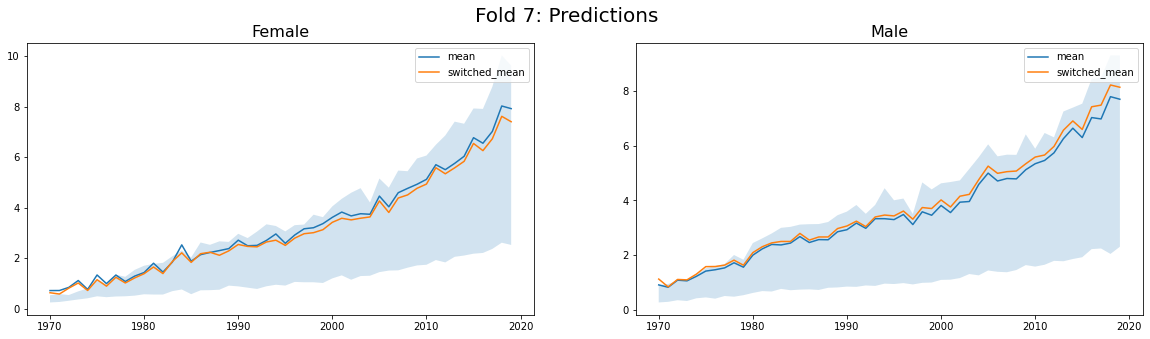

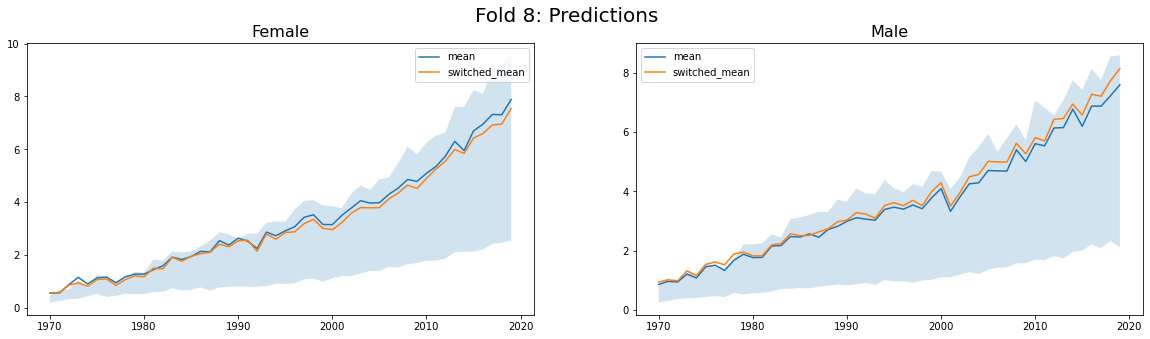

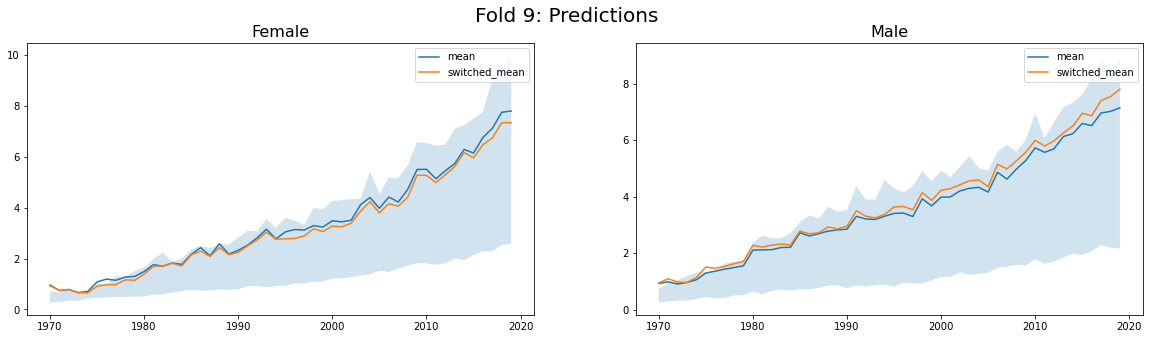

In [15]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    bias.plot_gs_results(r_test, r_switched_test, "year", "y_hat", "Fold {}: Predictions".format(i)).show()

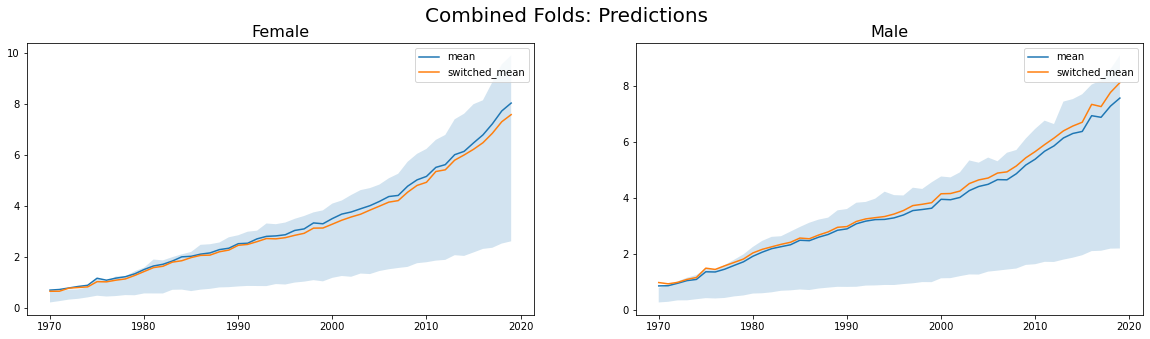

In [16]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "year", "y_hat", "Combined Folds: Predictions".format(i)).show()

## Graphical distibution of predictions by author seniority

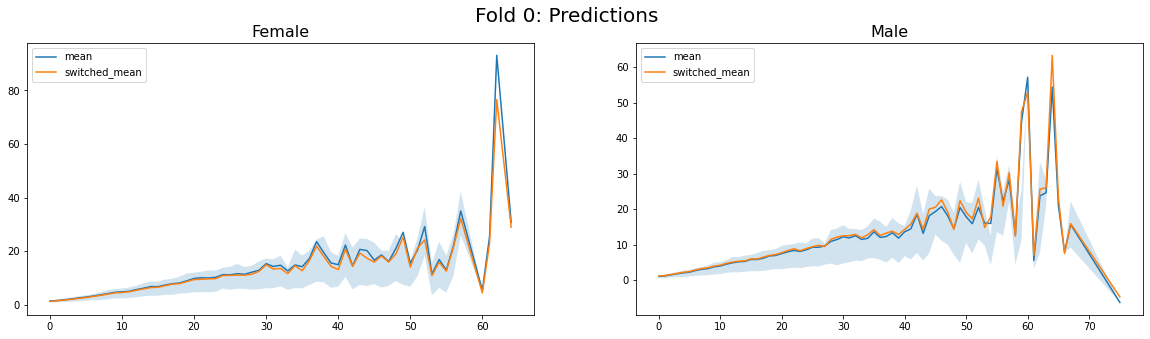

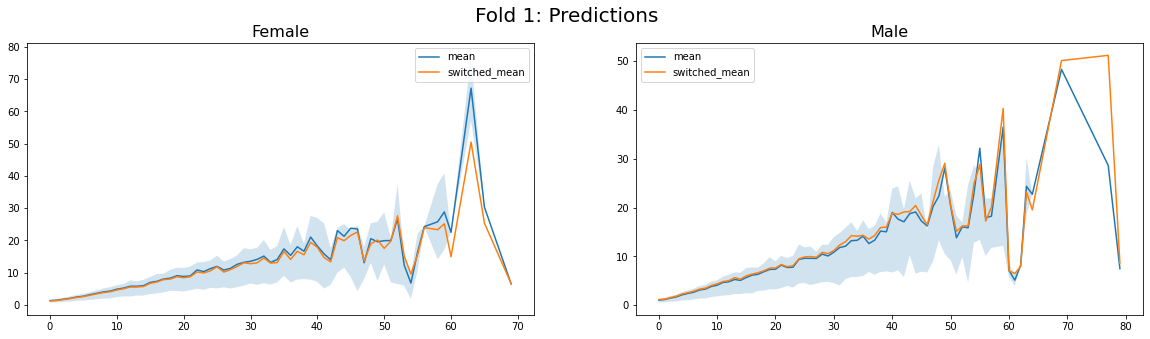

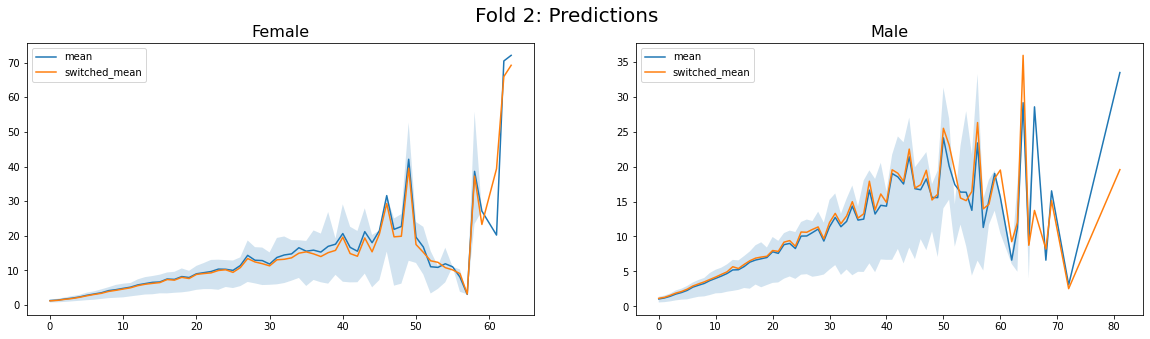

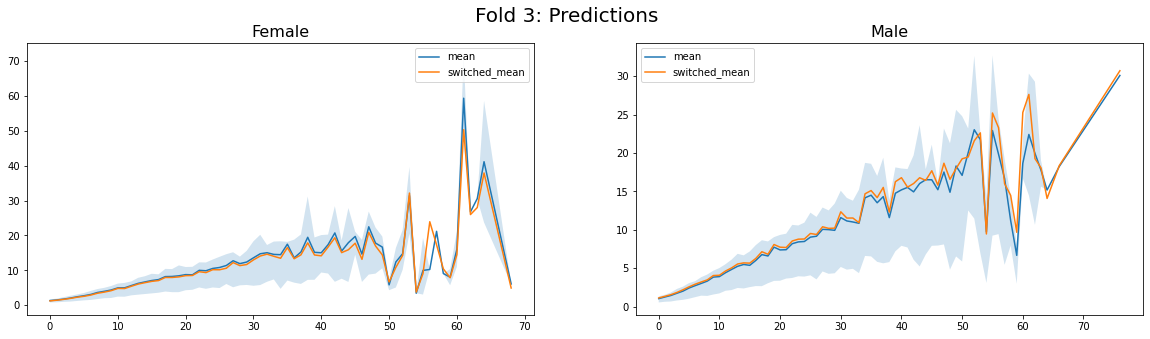

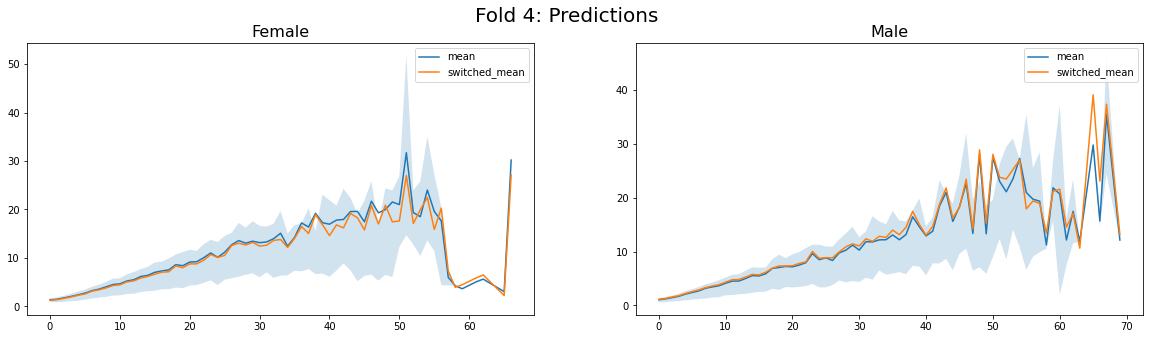

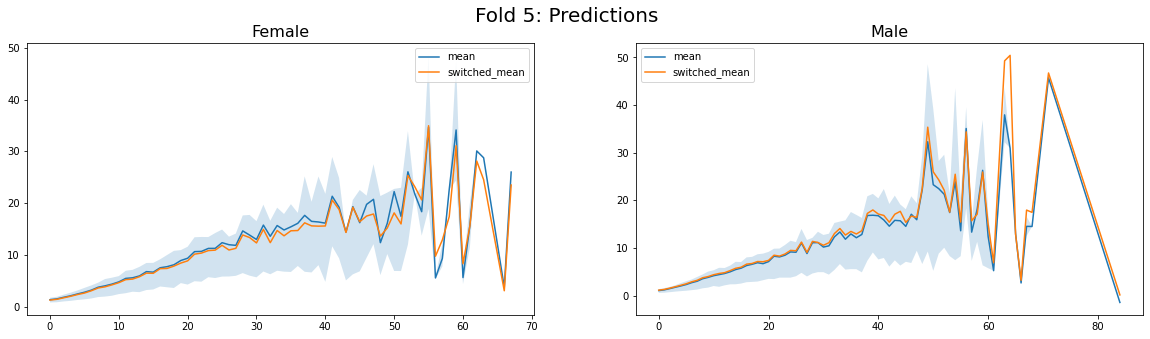

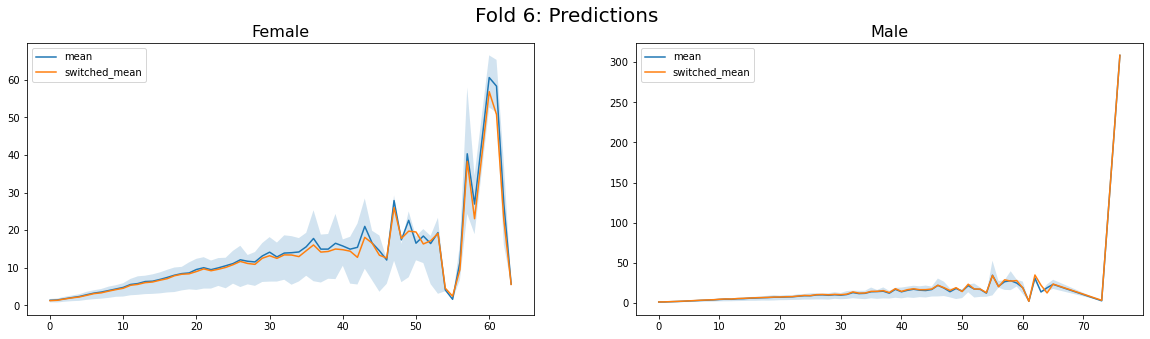

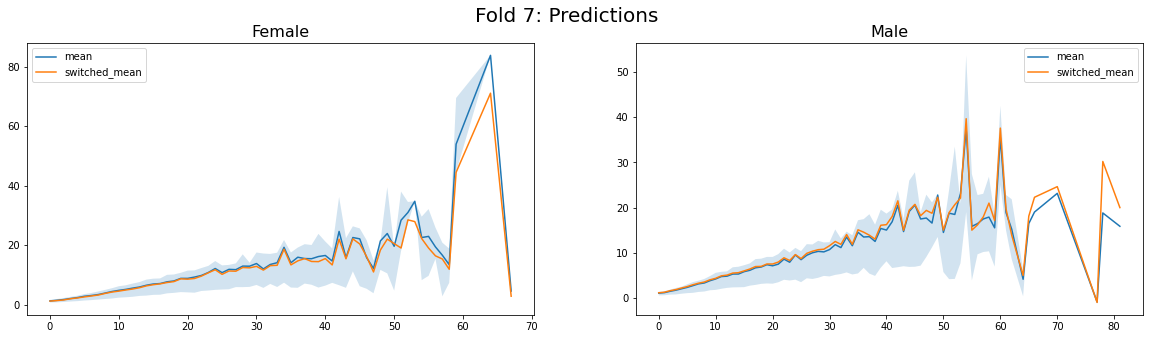

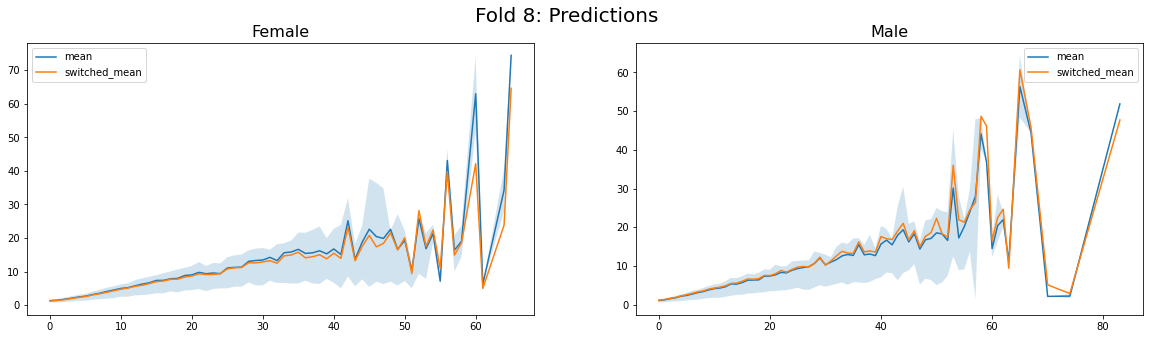

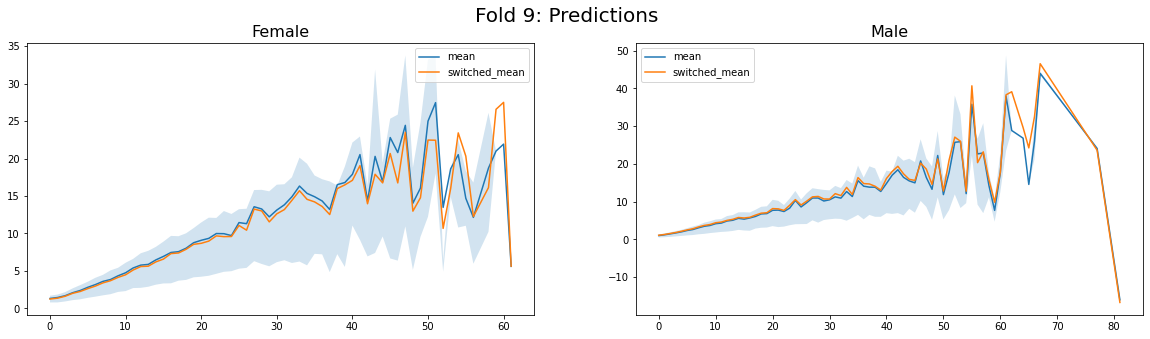

In [17]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_switched_test = switched_fold_results[i]
    
    bias.plot_gs_results(r_test, r_switched_test, "author_seniority", "y_hat", "Fold {}: Predictions".format(i)).show()

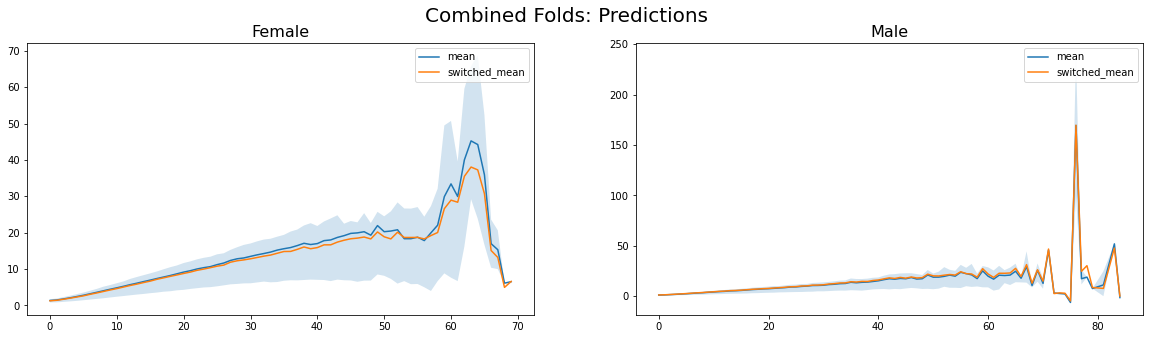

In [18]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "author_seniority", "y_hat", "Combined Folds: Predictions".format(i)).show()

## Graphical distibution of predictions by clustered number of publications per author

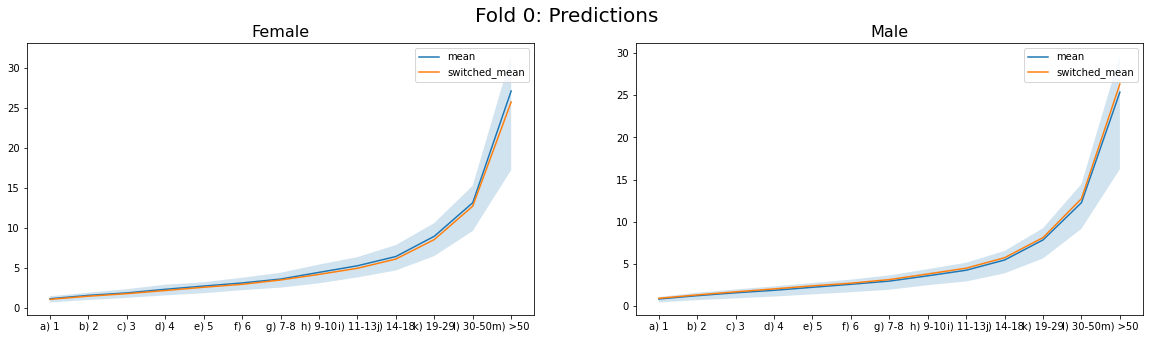

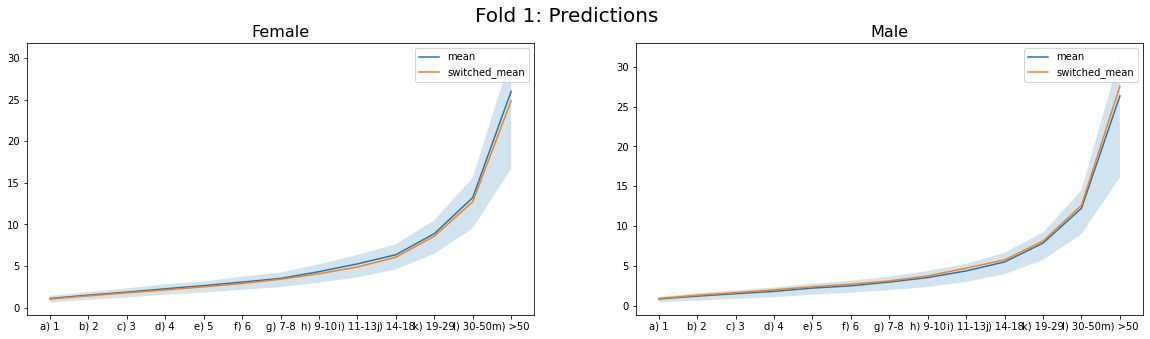

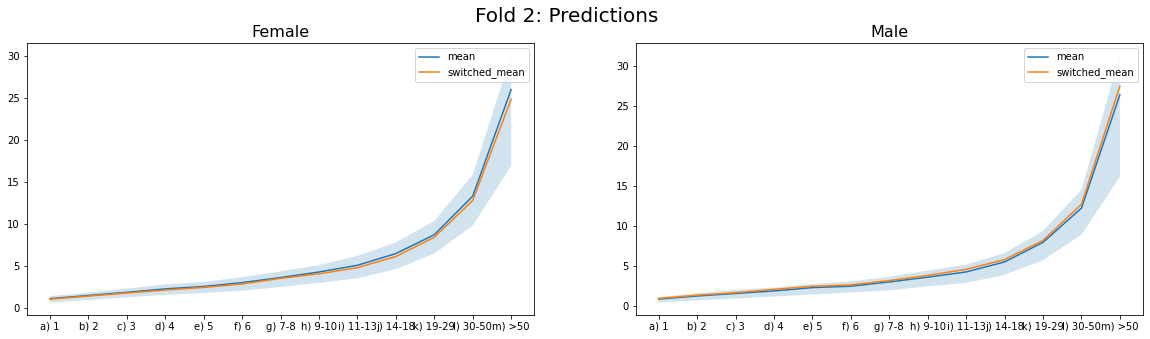

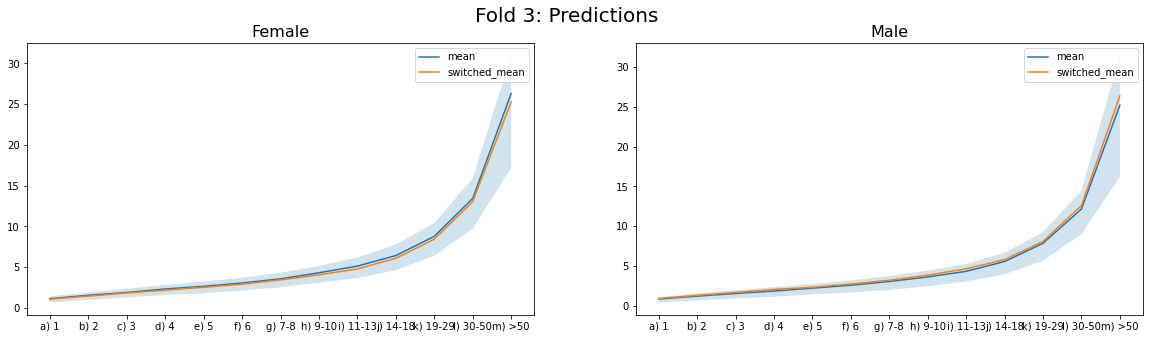

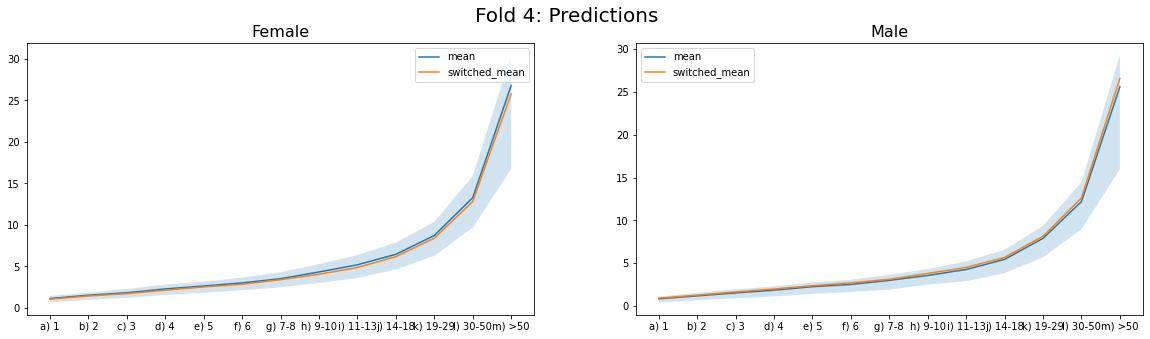

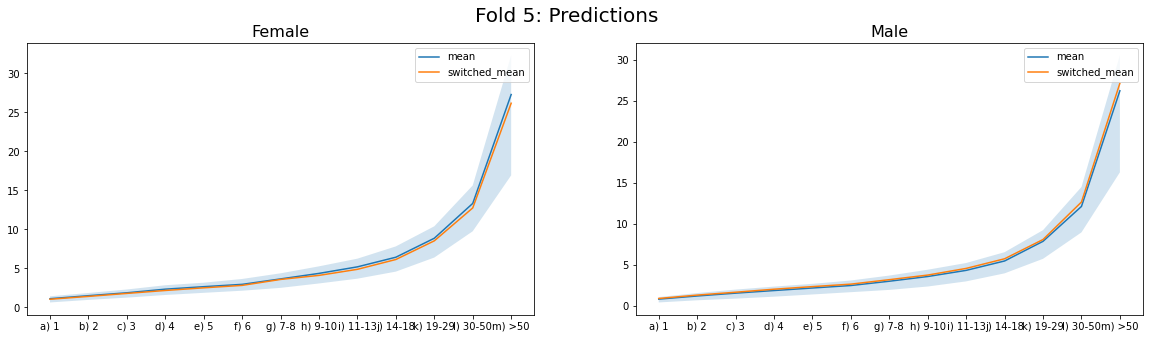

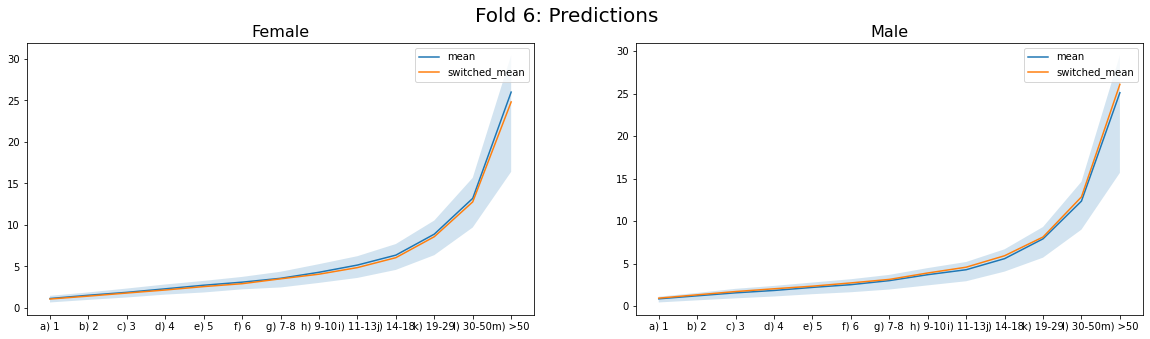

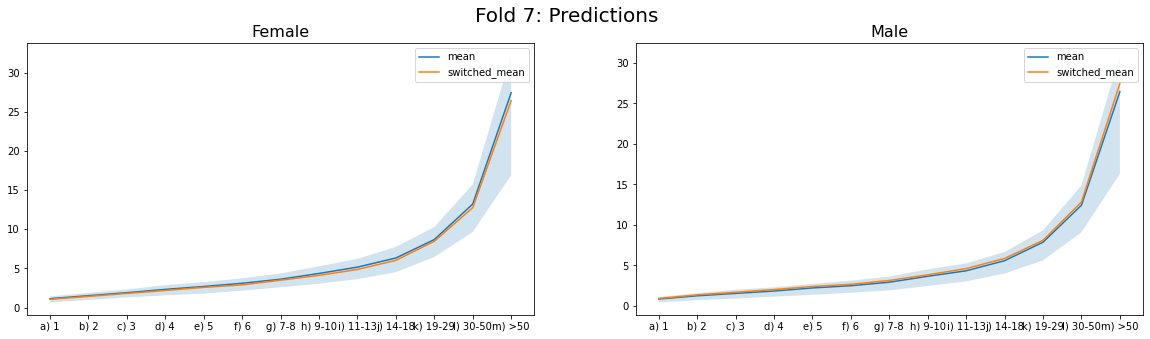

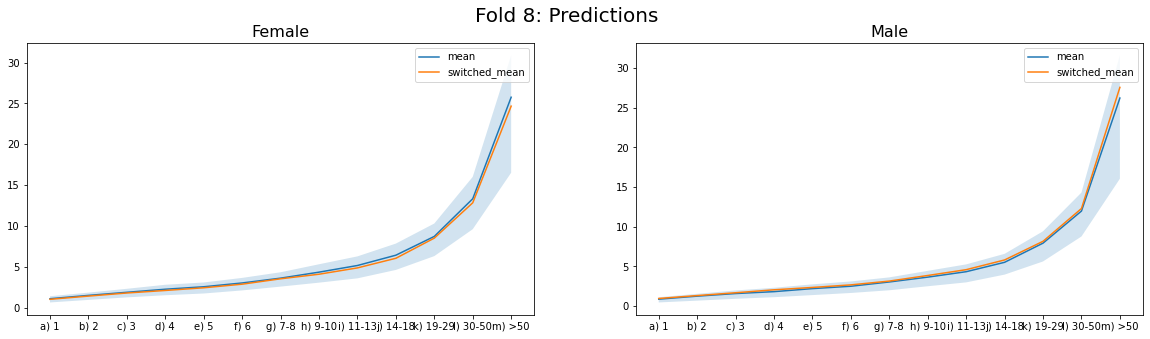

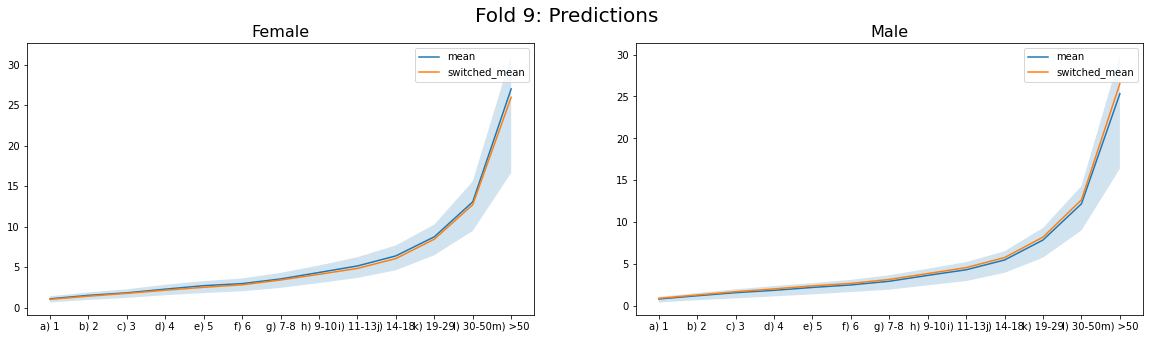

In [19]:
for i in range(len(fold_results)):
    _, r_test = fold_results[i]
    r_test = bias.cluster_column(r_test, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
    r_switched_test = switched_fold_results[i]
    r_switched_test = bias.cluster_column(r_switched_test, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
    
    bias.plot_gs_results(r_test, r_switched_test, "num_aggl_publications_cluster", "y_hat", "Fold {}: Predictions".format(i), x_categories=bias.PUBLICATION_COUNT_CLUSTERING).show()

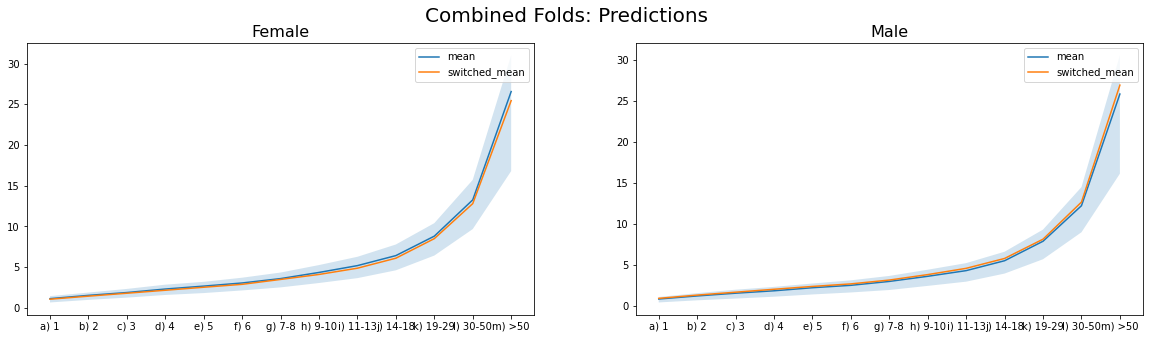

In [20]:
bias.plot_gs_results(r_test_all, r_switched_test_all, "num_aggl_publications_cluster", "y_hat", "Combined Folds: Predictions".format(i)).show()